In [5]:
from matplotlib.pyplot import *
import numpy as np
import h5py
from Data_Core.experiment import *
from Data_Core.digital_twin import *
from tqdm import tqdm
#from src.algorithms import *
#import torch
import sklearn
%load_ext autoreload
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts - w))

def find_index(wavelenghts,w):
    return np.argmin(np.abs(wavelenghts - w))

In [7]:
def Raman_data_loader(filename):

    with h5py.File(filename, 'a') as output_file:
         
        properties = output_file['properties']
        
        exp_properties = {'step_size' : np.array(properties['step_size'])[0],
                          'speed' : np.array(properties['speed']),
                          'n_points' : np.array(properties['n_points'])
            }
        
        wavelengths = np.array(output_file['properties']['x_data'])
        
        
        spot_numbers = [int(s.split('_')[-1]) for s in list(output_file['data'].keys()) if 'spot' in s ]
        
        Nx,Ny = output_file['properties']['n_points'][0], output_file['properties']['n_points'][1]
        Nl = len(wavelengths)
        spectral_signal = np.zeros([Nx,Ny,Nl])
        
        
        for _i, spot_number in enumerate(spot_numbers):

            ix, iy = int(spot_number//Ny), int(spot_number%Ny)
            
            spot = 'spot_'+str(spot_number)
            data = np.array(output_file['data'][spot]['raw_data'])
                      
            spectral_signal[ix,iy,:] = data
            

    return spectral_signal, wavelengths, exp_properties

In [8]:
filename = "2023913_1110.h5"
#filename = "2023811_1451.h5"
spectrum_raman, wavelengths_raman, exp_properties = Raman_data_loader(filename)

In [9]:
exp_properties

{'step_size': 0.2,
 'speed': array([b'5.000', b'5.000'], dtype=object),
 'n_points': array([250, 100])}

In [10]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_optimized(y, lam, p, niter = 10):
    L = len(y)
    D = sparse.diags([1, -2, 1],[0, -1, -2], shape = (L, L - 2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

In [11]:
lam = 1e2
p = 1e-1
    
pro_data = 1*spectrum_raman
for i in tqdm(range(0, pro_data.shape[0])):
    for j in range(0, pro_data.shape[1]):
        # print(i,j,end='\r')
        spec = 1 * pro_data[i, j, :]
        pro_data[i, j, :] = spec - baseline_als_optimized(spec, lam = lam, p = p, niter = 10)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [08:33<00:00,  2.05s/it]


In [12]:
pro_data_norm=pro_data.copy()
#for i in range(0,pro_data.shape[0]):
 #   for j in range(0,pro_data.shape[1]):
  #      spec = 1 * pro_data[i,j, :]
   #     sum_spec=np.sum(spec)
    #    pro_data_norm[i,j,:]=spec/sum_spec

In [13]:
offset_l = 31
offset_m = 328

mask = pro_data_norm[:, :, offset_l:offset_m].reshape(pro_data.shape[0]*pro_data.shape[1], -1)

wavelengths=wavelengths_raman[offset_l:offset_m]
# threshold = 120
# threshold2 = 0.01

# # Scaled to max value for each wavenumber
# # masks = np.array([mask[:, i]*(mask[:, i] > threshold)/np.max(mask[:, i]) for i in range(mask.shape[-1])])
# masks = np.array([np.array((mask[:, i]/np.max(mask[:, i]))*((mask[:, i] > threshold)) > threshold2, dtype = int) for i in range(mask.shape[-1])])

In [14]:
threshold = 1.27e-9

mask_offset = np.array(mask)
mask_t = np.array([(mask_offset[:, i])*((mask_offset[:, i] > threshold)) for i in range(mask_offset.shape[-1])])

In [15]:
from scipy.ndimage import gaussian_filter
mask_t=gaussian_filter(mask_t,sigma=0.7)

In [16]:
normalized_spec1=np.transpose(mask_t.reshape(297,250,100),axes=(1,2,0))

In [17]:

nx, ny = normalized_spec1.shape[1], normalized_spec1.shape[0]
dx = 0.2
dy = 0.2
 
freqs_x = 2*np.pi*np.fft.fftfreq(nx, dx)
freqs_y = 2*np.pi*np.fft.fftfreq(ny, dy)
 
def fft_feature(mmap, pixel_size_small):
    fft_map = np.array([np.fft.fftshift(np.fft.fft2(mmap[:, :, i])) for i in tqdm(range(0, (mmap.shape[-1])))])
    fft_map[:, fft_map.shape[1]//2, fft_map.shape[2]//2] = 0
 
    kxx, kyy = np.meshgrid(np.fft.fftshift(freqs_x), np.fft.fftshift(freqs_y))
 
    object_size_small = pixel_size_small*dx
    size_kspace_small = 2*np.pi/object_size_small/2*1.5
 
    R = abs(np.sqrt(kxx**2 + kyy**2))
 
    sum1 = np.sum(np.abs(fft_map[:,(R < size_kspace_small)]), axis = (1))
    max1 = np.sum(np.abs(fft_map), axis = (1, 2))
 
    sums = np.array(sum1)/np.array(max1)
 
    return sums, fft_map
 
sums, fft_m = fft_feature(normalized_spec1, 5)

100%|███████████████████████████████████████████████████████████████████████████████| 297/297 [00:00<00:00, 700.74it/s]


In [18]:
minerals = {
    
    'Albite':[508.1],
    'Background':[733.1],
    'Petalite':[491.3],
    'Quartz':[463.92],
    'Spodumene':[704.5]}

mineral_list = list(minerals.keys())

find_index = lambda wavelenghts,w : np.argmin(np.abs(wavelengths-w))

significant_w=[]
for i,mineral in enumerate(mineral_list):
    wn=find_index(wavelengths,minerals[mineral][0])
    significant_w.append(wn)

<IPython.core.display.Javascript object>


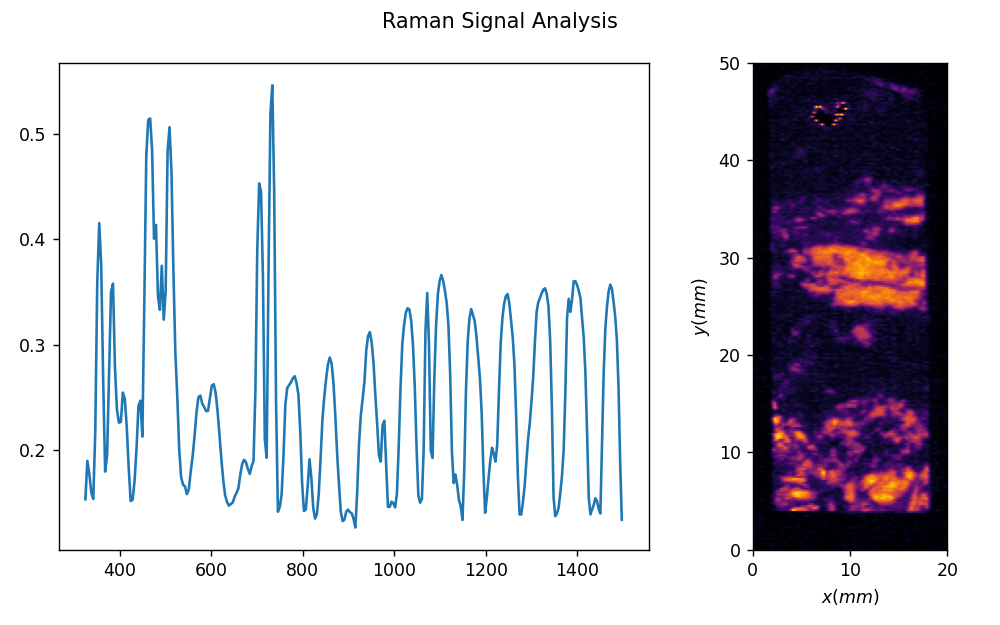

In [19]:
%matplotlib notebook
fig, ax = subplots(1,2, figsize = (8, 5), gridspec_kw = {'width_ratios': [0.9, 0.4]})
fig.suptitle('Raman Signal Analysis')

axs = ax[0]
axs.plot(wavelengths,sums)
axs = ax[1]
axs.imshow(normalized_spec1[:, :, wn], cmap = cm.inferno, extent = [0, exp_properties['step_size']*exp_properties['n_points'][1],
                                                        0, exp_properties['step_size']*exp_properties['n_points'][0]])
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')


def update_map(wn):
    im = ax[1].imshow(normalized_spec1[:, :, wn], cmap = cm.inferno,
                      extent = [0, exp_properties['step_size']*exp_properties['n_points'][1],
                            0, exp_properties['step_size']*exp_properties['n_points'][0]],
                     interpolation = 'none')
    line.set_xdata(wavelengths_raman[offset_l:offset_m][wn])

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths_raman[offset_l:offset_m], ix)
    if event.inaxes == ax[0] or ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()

<IPython.core.display.Javascript object>


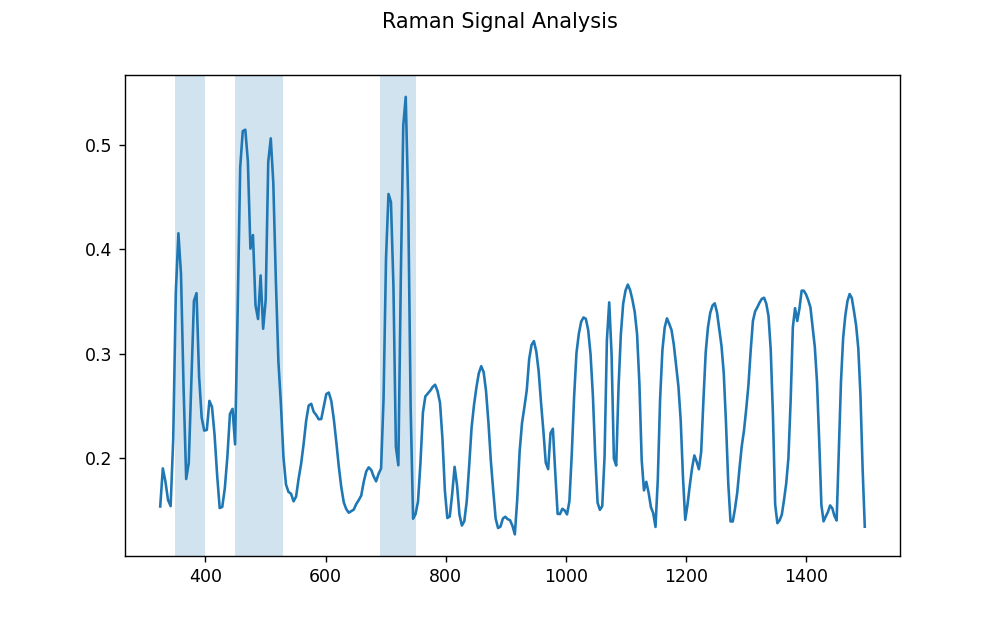

In [20]:
fig, ax = subplots(figsize = (8, 5))
fig.suptitle('Raman Signal Analysis')

axs = ax
axs.plot(wavelengths,sums)
axs.axvspan(350, 400, ymin=0, ymax=1, alpha=0.2)

axs.axvspan(450, 530, ymin=0, ymax=1, alpha=0.2)

axs.axvspan(690, 750, ymin=0, ymax=1, alpha=0.2)

<IPython.core.display.Javascript object>


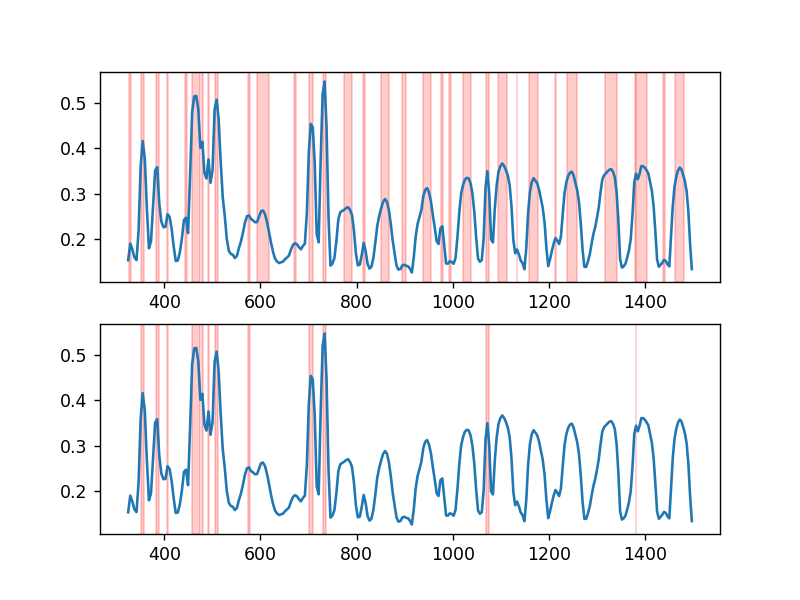

In [21]:
threshold = 1.27e-9

mask_offset = np.array(mask)
mask_t = np.array([(mask_offset[:, i])*((mask_offset[:, i] > threshold)) for i in range(mask_offset.shape[-1])])



peaks=scipy.signal.find_peaks(sums)[0]
heights=sums[peaks]
widths=scipy.signal.peak_widths(sums, peaks)[0]
fig,ax=subplots(2)
axs = ax[0]
axs.plot(wavelengths,sums)

for i in range(len(widths)):
    axs.axvspan(wavelengths[peaks[i]]-widths[i],wavelengths[peaks[i]]+widths[i], ymin=0, ymax=1, alpha=0.2,color='red')

axs=ax[1]
axs.plot(wavelengths,sums)
#print(widths)
#print(heights)
new_selected_maps=[]

il=[]
im=[]

for i in range(len(widths)):
    if widths[i]<=8.05 and heights[i]>0.25:
        axs.axvspan(wavelengths[peaks[i]]-widths[i],wavelengths[peaks[i]]+widths[i], ymin=0, ymax=1, alpha=0.2,color='red')
        il.append(find_index(wavelengths,wavelengths[peaks[i]]-widths[i]))
        im.append(find_index(wavelengths,wavelengths[peaks[i]]+widths[i]))
        
for j in range(len(il)):
    
    for k in range(il[j],im[j]+1):
        new_selected_maps.append(mask_t[k])
    

In [22]:
from scipy.ndimage import gaussian_filter
mask_t=np.array(new_selected_maps)
#mask_t=gaussian_filter(mask_t,sigma=0.7)
mask_min_max = np.array([(mask_t[i, :] - mask_t[:, :].min())/(mask_t[:, :].max() - mask_t[:, :].min()) for i in range(mask_t.shape[0])])

C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<IPython.core.display.Javascript object>


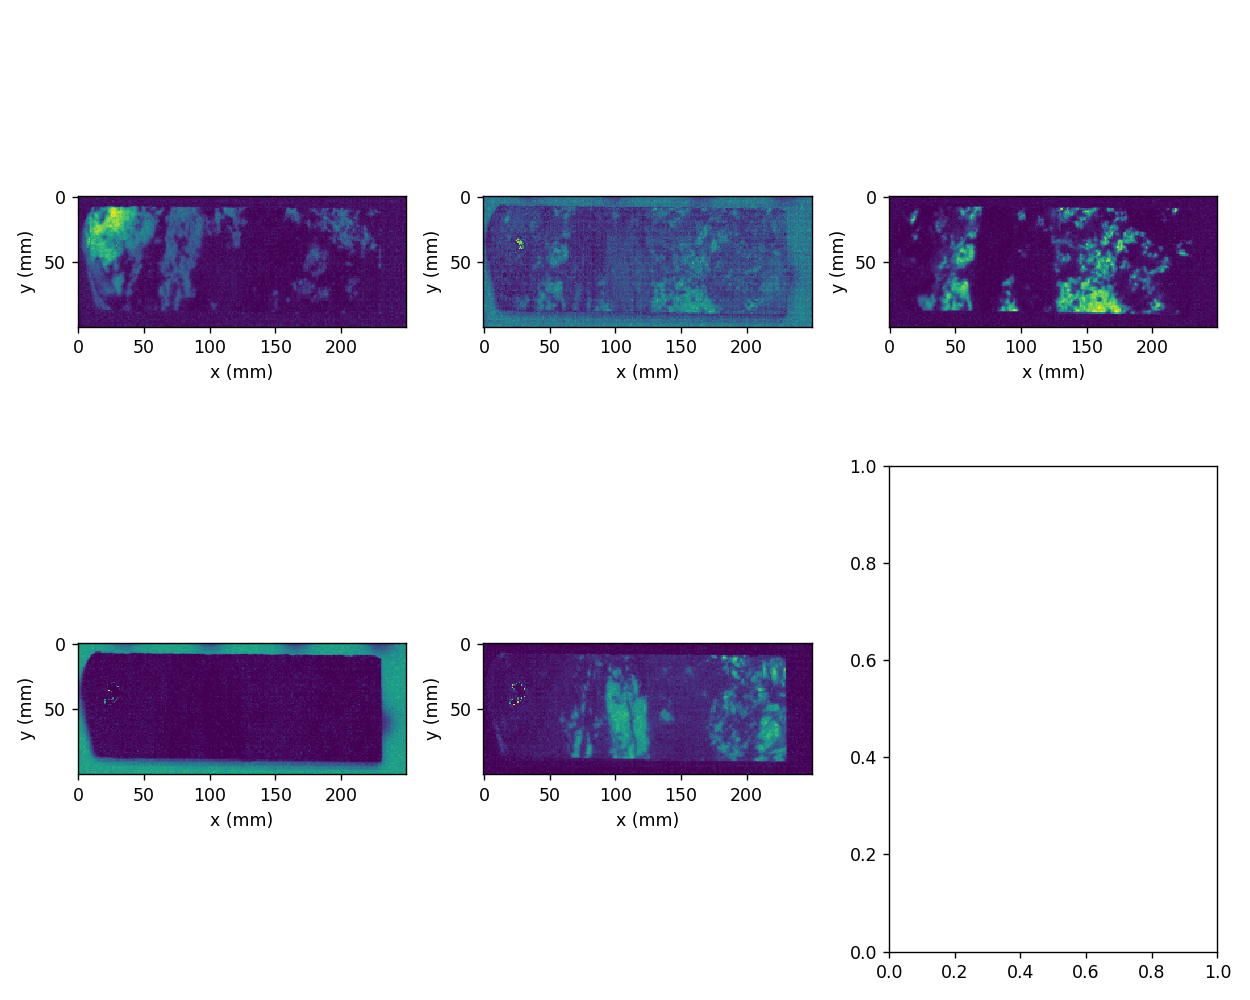

In [23]:
kmeans = sklearn.cluster.KMeans(n_clusters = 5,random_state=0)
a=kmeans.fit_predict(mask_min_max)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

<IPython.core.display.Javascript object>


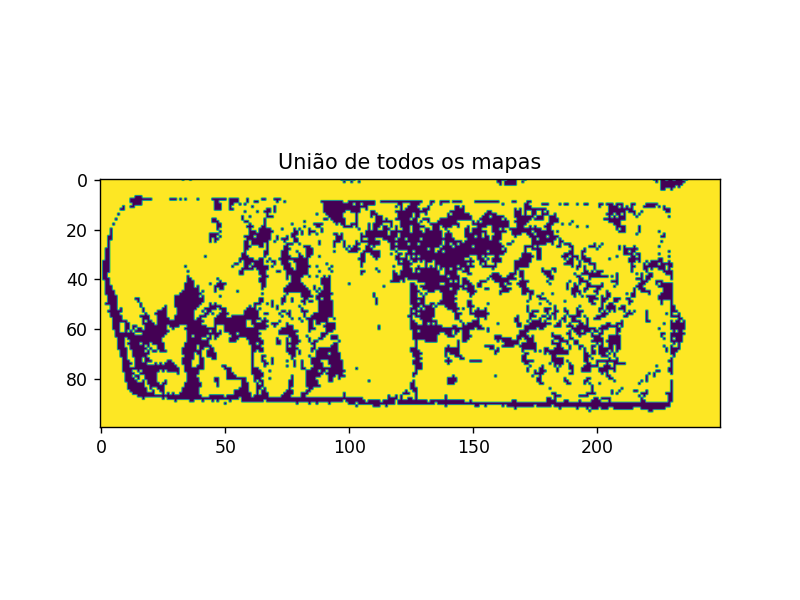

Área de cobertura 75.0 %


In [24]:
from skimage.filters import threshold_otsu
import cv2
thresholds=np.array([threshold_otsu(clusters_c[i]) for i in range(clusters_c.shape[0])])

cluster_thres=[]
for i in range(clusters_c.shape[0]):
    c_mask=np.zeros(clusters_c.shape[1])
    for j in range(clusters_c.shape[1]):
        if clusters_c[i][j]>thresholds[i]:
            c_mask[j]=1
    cluster_thres.append(c_mask.reshape(pro_data.shape[0],pro_data.shape[1]))
    
    
img_or = cluster_thres[0]

for img in cluster_thres[1:]:
    img_or = cv2.bitwise_or(img_or, img)
fig,ax=subplots()    
ax.imshow(img_or.T)
plt.title('União de todos os mapas')
#uniao de todos os mapas
cut_int=img_or.copy()
print('Área de cobertura',round(sum(cut_int)/(cut_int.shape[0]*cut_int.shape[1]),2)*100, '%')

## Threshold antes do clustering

C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<IPython.core.display.Javascript object>


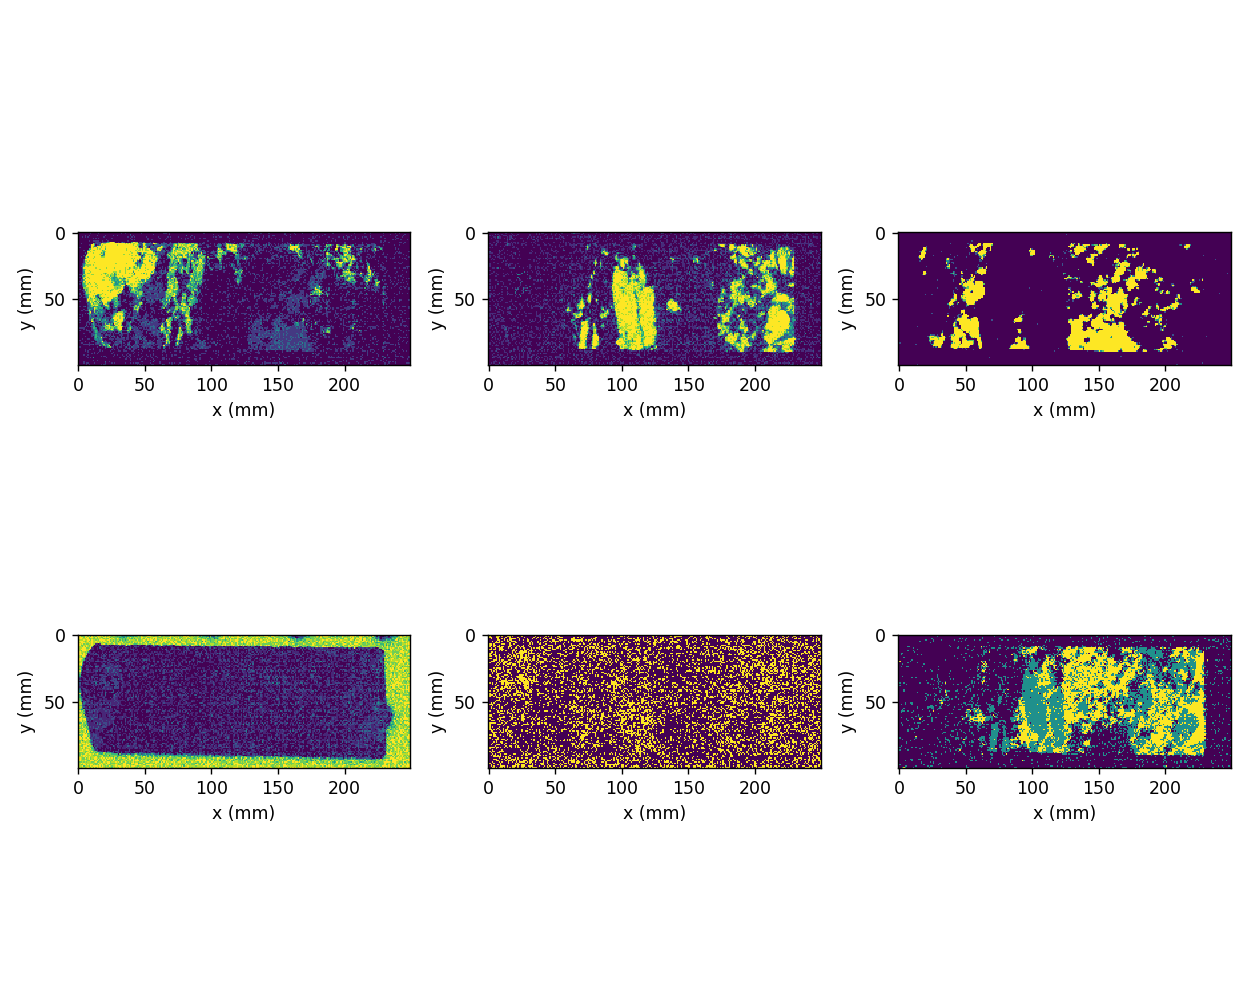

In [28]:
from skimage.filters import threshold_otsu
import cv2
thresholds=np.array([threshold_otsu(mask_min_max[i]) for i in range(mask_min_max.shape[0])])

maps_thres=[]
for i in range(mask_min_max.shape[0]):
    c_mask=np.zeros(mask_min_max.shape[1])
    for j in range(mask_min_max.shape[1]):
        if mask_min_max[i][j]>thresholds[i]:
            c_mask[j]=1
    maps_thres.append(c_mask)
maps_thres=np.array(maps_thres)  

kmeans = sklearn.cluster.KMeans(n_clusters = 6,random_state=0)
a=kmeans.fit_predict(maps_thres)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()


In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax=subplots()
# Assuming cluster_thres is a NumPy array containing your images

# Create a subplot with enough space for all the intersections
num_images = np.array(cluster_thres).shape[0]
num_subplots = num_images * (num_images - 1) // 2
minerals_order=['Quartzo','Albite','Spodumeno','Background']


for i in range(num_images):

    for j in range(i + 1, num_images):
        # Calculate the intersection
        img_and = cv2.bitwise_and(cluster_thres[i], cluster_thres[j])
        
        plt.imshow(img_and)
        plt.title(f'Intersection {minerals_order[i]} and {minerals_order[j]}')
        plt.axis('off')
        plt.show()
        

In [ ]:
fig_ar=pro_data.shape[0]*pro_data.shape[1]
areas=[]
for i in range (len(cluster_thres)):
    a=np.sum(cluster_thres[i])
    areas.append(a)
areas.append((fig_ar-np.sum(areas)))
labels=['Quartzo','Albite','Spodumeno','Background','Resto']
fig, ax = plt.subplots()
ax.pie(areas, labels=labels,autopct='%1.1f%%')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming pro_data and cluster_thres are defined before this code
fig_ar = pro_data.shape[0] * pro_data.shape[1]
areas = []

for i in range(len(cluster_thres)):
    a = np.sum(cluster_thres[i])
    areas.append(a)

areas.append((fig_ar - np.sum(areas)))
labels = ['Quartzo', 'Albite', 'Spodumeno', 'Background', ' ']

fig, ax = plt.subplots()

# Draw a white circle in the center to create a donut plot
centre_circle = plt.Circle((0, 0), color='white', edgecolor='black', linewidth=0.9)
ax.add_artist(centre_circle)

ax.pie(areas, labels=labels, autopct='%1.1f%%', wedgeprops=dict(width=0.27, edgecolor='w'))

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')  
plt.show()


In [ ]:
selected_masks=[]
bands=np.array([(350,400),(450,530),(690,750)])
index_bands=[]
for i in range(len(bands)):
    index_bands.append((find_index(wavelengths,bands[i][0]),find_index(wavelengths,bands[i][1])))

mask_t = np.array([(mask_offset[:, i])*((mask_offset[:, i] > threshold)) for i in range(mask_offset.shape[-1])])
mask_t_g=gaussian_filter(mask_t,sigma=0.5)
for i in range(mask_t.shape[0]):
    if index_bands[0][0]<=i<=index_bands[0][1] or index_bands[1][0]<=i<=index_bands[1][1] or index_bands[2][0]<=i<=index_bands[2][1]:
        selected_masks.append(mask_t_g[i])

In [ ]:
np.array(selected_masks).shape

In [ ]:
mask_t=np.array(selected_masks)

In [ ]:
mask_min_max = np.array([(mask_t[i, :] - mask_t[:, :].min())/(mask_t[:, :].max() - mask_t[:, :].min()) for i in range(mask_t.shape[0])])

In [ ]:
fig, ax = subplots(figsize = (8, 5))
fig.suptitle('Raman Signal Analysis')

axs = ax
axs.plot(wavelengths,sums)
axs.axvspan(350, 400, ymin=0, ymax=1, alpha=0.2)

axs.axvspan(450, 530, ymin=0, ymax=1, alpha=0.2)

axs.axvspan(690, 750, ymin=0, ymax=1, alpha=0.2)

In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters = 6,random_state=0)
a=kmeans.fit_predict(mask_min_max)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

## LIBS

In [ ]:
filename = "PetalideEspodumena_ADG-2-40-8_map"
#filename = "2023811_1451.h5"
#filename = "2023811_1451.h5"
def read_data_map(file):
 
    hf = h5py.File(file + '.h5', 'r')
    sample = file.split("\\")[-1]
    keys = [key for key in hf.keys()]
    sample = keys[0].split(' ')[-1]
 
    spectrums = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['Shot_0']['Pro']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    positions = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['position']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    wavelengths = np.array(hf['System properties']['wavelengths'])
 
   
    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
   
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:, 0],positions[:, 1]))
    spectrums = spectrums[indexes, :]
    spectrums = np.array(spectrums.reshape((ny, nx, -1)))
    # print(spectrums.shape)
    positions = np.array(positions[indexes])
   
    hf.close()
    return spectrums, wavelengths, positions, unique_x, unique_y
spectrum, wavelengths, positions,unique_x,unique_y = read_data_map(filename)

pro_data = 1*spectrum

pro_data_norm=pro_data.copy()
for i in range(0,pro_data.shape[0]):
    for j in range(0,pro_data.shape[1]):
        spec = 1 * pro_data[i,j, :]
        sum_spec=np.sum(spec)
        pro_data_norm[i,j,:]=spec/sum_spec
mask = pro_data_norm[:, :, :].reshape(pro_data.shape[0]*pro_data.shape[1], -1)
       
threshold = 1.27e-9

mask_offset = np.array(mask)
mask_t = np.array([(mask_offset[:, i])*((mask_offset[:, i] > threshold)) for i in tqdm(range(mask_offset.shape[-1]))])


In [ ]:
normalized_spec1=np.transpose(mask_t.reshape(-1,50,110),axes=(1,2,0))

In [ ]:

nx, ny = normalized_spec1.shape[1], normalized_spec1.shape[0]
dx = 0.5
dy = 0.5
 
freqs_x = 2*np.pi*np.fft.fftfreq(nx, dx)
freqs_y = 2*np.pi*np.fft.fftfreq(ny, dy)
 
def fft_feature(mmap, pixel_size_small):
    fft_map = np.array([np.fft.fftshift(np.fft.fft2(mmap[:, :, i])) for i in tqdm(range(0, (mmap.shape[-1])))])
    fft_map[:, fft_map.shape[1]//2, fft_map.shape[2]//2] = 0
 
    kxx, kyy = np.meshgrid(np.fft.fftshift(freqs_x), np.fft.fftshift(freqs_y))
 
    object_size_small = pixel_size_small*dx
    size_kspace_small = 2*np.pi/object_size_small/2*1.5
 
    R = abs(np.sqrt(kxx**2 + kyy**2))
 
    sum1 = np.sum(np.abs(fft_map[:,(R < size_kspace_small)]), axis = (1))
    max1 = np.sum(np.abs(fft_map), axis = (1, 2))
 
    sums = np.array(sum1)/np.array(max1)
 
    return sums, fft_map
 
sums, fft_m = fft_feature(normalized_spec1, 10)

In [ ]:
minerals = {
    
    'Li':[610.22],
    'Na':[588.99],
    'Al':[309.27],
    'Si':[288.13]}
mineral_list = list(minerals.keys())
wavelengths=wavelengths.flatten()
find_index = lambda wavelenghts,w : np.argmin(np.abs(wavelengths-w))

significant_w=[]
for i,mineral in enumerate(mineral_list):
    wn=find_index(wavelengths,minerals[mineral][0])
    significant_w.append(wn)
    
%matplotlib notebook
fig, ax = subplots(1,2, figsize = (9, 5), gridspec_kw = {'width_ratios': [0.9, 0.4]})
fig.suptitle('Raman Signal Analysis')

axs = ax[0]
axs.plot(wavelengths,sums)
axs = ax[1]
axs.imshow(normalized_spec1[:, :, wn], cmap = cm.inferno)
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')


def update_map(wn):
    im = ax[1].imshow(normalized_spec1[:, :, wn], cmap = cm.inferno,
                     interpolation = 'none')
    line.set_xdata(wavelengths_raman[offset_l:offset_m][wn])

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths_raman[offset_l:offset_m], ix)
    if event.inaxes == ax[0] or ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()

In [ ]:
peaks=scipy.signal.find_peaks(sums)[0]
sel_maps=[]
for i in range(len(peaks)):
    sel_maps.append(mask_t[peaks[i]])

In [ ]:
np.array(sel_maps).shape

In [ ]:
mask_t=np.array(sel_maps)
mini=mask_t.min()
maxi=mask_t.max()
mask_min_max = np.array([(mask_t[i, :] - mini)/(maxi - mini) for i in tqdm(range(mask_t.shape[0]))])


In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters = 5,random_state=0)
a=kmeans.fit_predict(mask_min_max)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]), interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1


        
axs=ax[0,0]
axs.set_title('Si')        
axs=ax[0,1]
axs.set_title('Li')
axs=ax[0,2]
axs.set_title('Na')
axs=ax[1,0]
axs.set_title('Al')

axs=ax[1,1]
axs.set_title('Background')
fig.tight_layout()        
fig.tight_layout()